In [1]:
import time

In [2]:
start = time.time()

In [3]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import ensemble
import matplotlib.pyplot as plt
import os

from functions.pipeline import *

In [4]:
SEED = 123
np.random.seed(SEED)

In [5]:
p = os.path.dirname(os.path.realpath(__name__))
path = f"{p}/data/data.csv"
df = pd.read_csv(path)
matrix, target = Gx.processing(df)

In [6]:
df.head(2)

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127


In [7]:
matrix.head(2)

left_ankle  left_knee   left_hip  right_ankle  right_knee  \
trial time                                                              
1     0       4.682881   3.693683  16.607868     5.015829    2.244425   
      1       5.073127   4.258876  16.851029     5.291201    3.381678   

            right_hip  
trial time             
1     0      18.94829  
      1      19.26530

In [8]:
target.head(2)

1    1
2    1
Name: condition, dtype: int64

<Axes: xlabel='time'>

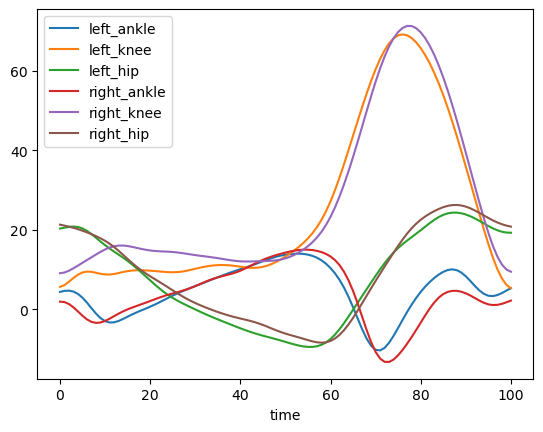

In [9]:
# knee brace
subject_no = 2
condition_no = 1
rep_no = 3
idx = (N_REPS * N_CONDITIONS) * (subject_no - 1) + N_REPS * (condition_no - 1) + (rep_no % N_REPS)
matrix.loc[idx, :].plot()

# Feature Extraction

In [10]:
n_splits = 4
feature_sets = Gx.create_feature_sets(matrix, n_splits)
feature_set_names = ["base"] + [f"covs_split_{i}" for i in range(1, n_splits + 1)]
feature_set_dict = dict(zip(feature_set_names, feature_sets))

In [11]:
feature_set_dict["base"].head(2)

,left_ankle_mean,left_knee_mean,left_hip_mean,right_ankle_mean,right_knee_mean,right_hip_mean
trial,,,,,,
1,7.850984,21.860145,4.597241,7.061943,22.231482,5.737394
2,7.003371,22.046200,2.934972,7.019926,24.393793,7.028008


In [12]:
feature_set_dict["covs_split_1"].head(2)

,ankle_1_1,knee_1_1
trial,,
1,19.994342,332.00362
2,21.547690,370.86164


# Testing Model

In [13]:
feature_valid_errors = []
optimals = []

for i, features in enumerate(feature_sets):
    print(f"\n\nSet {i+1}:\n")
    all_errors, optimal = Gx.grid_search(features, target)

    optimals.append(optimal)
    feature_valid_errors.append(optimal.mean_error)



Set 1:

4% complete.
8% complete.
12% complete.
16% complete.
20% complete.
24% complete.
28% complete.
32% complete.
36% complete.
40% complete.


In [ ]:
hyperparameter_choices = dict(zip(feature_set_names, optimals))

valid_errors = dict(zip(feature_set_names, feature_valid_errors))
lowest_error_idx = pd.Series(valid_errors).argmin()
optimal_feature_set_name = list(valid_errors)[lowest_error_idx]

In [ ]:
valid_errors

In [ ]:
optimal_feature_set_name

In [ ]:
z = scipy.stats.norm.ppf(.95)
optimal_hps = hyperparameter_choices[optimal_feature_set_name]

lower_conf = optimal_hps.mean_error - z * optimal_hps.stdev_error 
lower_conf = max(0, lower_conf)
upper_conf = optimal_hps.mean_error + z * optimal_hps.stdev_error 
conf_interval = (lower_conf, upper_conf)
conf_interval

In [ ]:
hyperparams = ["max_depth", "min_impurity_decrease"]
indexed_errors = all_errors.set_index(hyperparams)
indexed_errors.mean_error

# Test Data

In [ ]:
features = feature_set_dict[optimal_feature_set_name]
X_train, y_train, X_test, y_test = Gx.train_test_split(features, target)

model = ensemble.GradientBoostingClassifier(
    n_estimators=N_ESTIMATORS, 
    max_depth=int(optimal_hps.loc["max_depth"]), 
    min_impurity_decrease=float(optimal_hps.loc["min_impurity_decrease"]), 
    loss="log_loss"
    )

error_test, y_test_probs = Gx.run_model(X_train, y_train, X_test, y_test, model)

In [ ]:
error_test # essentially zero!

In [ ]:
pd.DataFrame(y_test_probs).plot()

In [ ]:
# ten subjects
# ten replications
# three conditions

# 6 measurements for each one (two legs, three joints)
# time series are 101 points long
# so the data is actually (300 x 101 x 6), so we should represent it as such.

# train-test split: 
# 7 subjects for train: should do leave-one-out validation (as in 1 subject each time)
# 3 subjects for test: leave three subjects for test

In [ ]:
# to do:

# create cov features by splitting the data (e.g. first half / second half)

In [ ]:
end = time.time()

time_taken = round(end - start, 2)
print(f"Time taken: {time_taken}s")